In [1]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [7]:
TRAIN_DATASET_PATH = 'MICCAI-1/MICCAI-BraTS2024-MET-Challenge-Training_1/'
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS-MET-00002-000/BraTS-MET-00002-000-t2f.nii.gz').get_fdata()
print(test_image_flair.max())

461.1625671386719


In [8]:
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [9]:
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS-MET-00002-000/BraTS-MET-00002-000-t1n.nii.gz').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS-MET-00002-000/BraTS-MET-00002-000-t1c.nii.gz').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS-MET-00002-000/BraTS-MET-00002-000-t2w.nii.gz').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS-MET-00002-000/BraTS-MET-00002-000-seg.nii.gz').get_fdata()
test_mask=test_mask.astype(np.uint8)

[0 1 2 3]
[0 1 2 3]


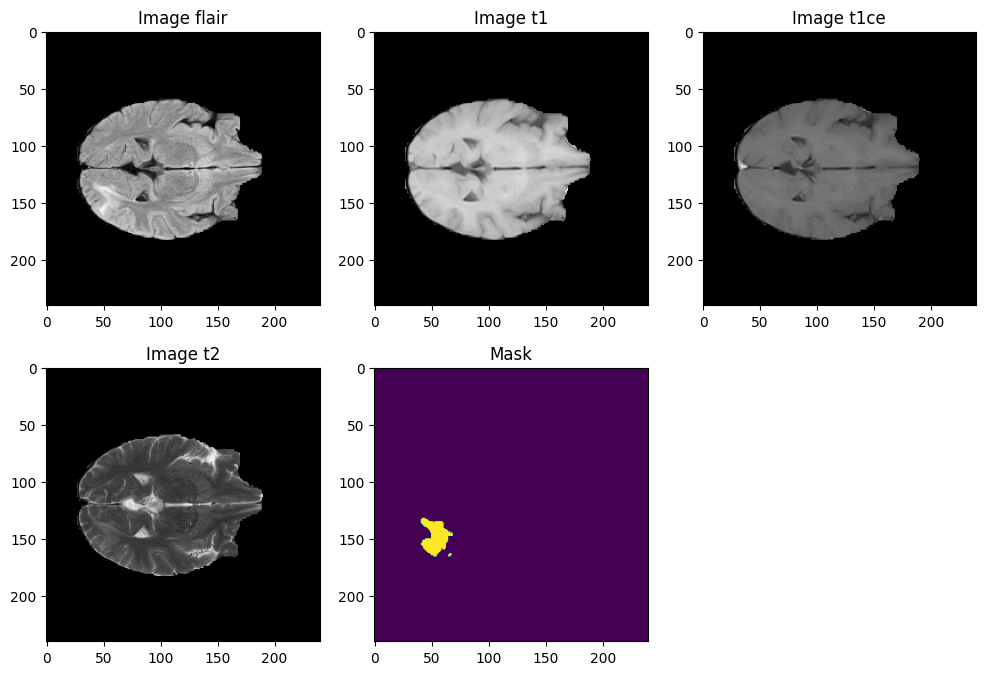

In [18]:
print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

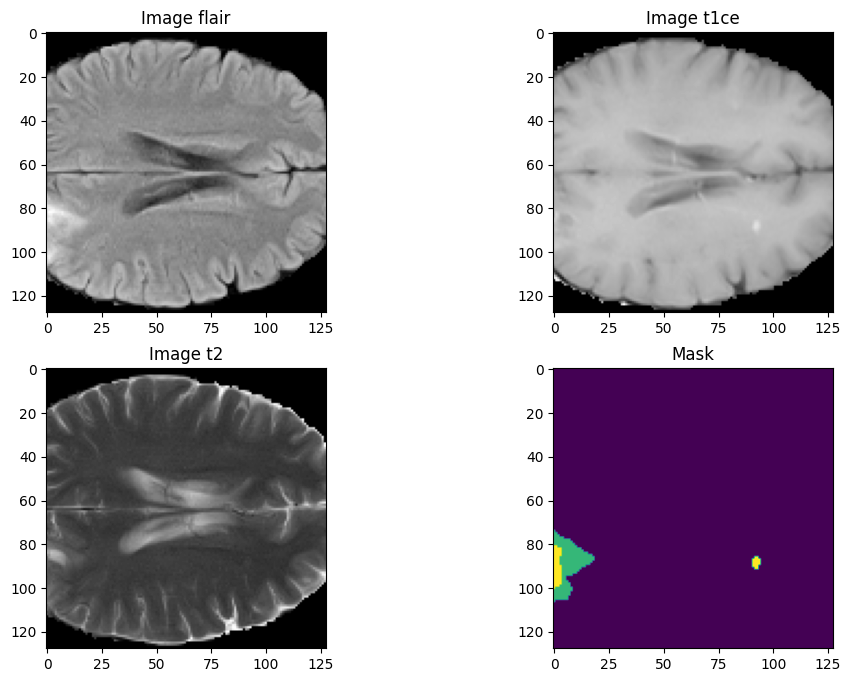

In [19]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()
####################################################################
#####################################
#End of understanding the dataset. Now get it organized.
#####################################

#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

#Keras datagenerator does ntot support 3d


In [20]:
imwrite('ml2-combined255.tif', combined_x)
np.save('ml2-combined255.npy', combined_x)
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

my_img=np.load('ml2-combined255.npy')

test_mask = to_categorical(test_mask, num_classes=4)

C:\Users\Dhingra\AppData\Local\Temp\ipykernel_27116\690361304.py:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('ml2-combined255.tif', combined_x)


In [33]:
#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('MICCAI-1/MICCAI-BraTS2024-MET-Challenge-Training_1/*/*t2w.nii.gz'))
t1ce_list = sorted(glob.glob('MICCAI-1/MICCAI-BraTS2024-MET-Challenge-Training_1/*/*t1c.nii.gz'))
flair_list = sorted(glob.glob('MICCAI-1/MICCAI-BraTS2024-MET-Challenge-Training_1/*/*t2f.nii.gz'))
mask_list = sorted(glob.glob('MICCAI-1/MICCAI-BraTS2024-MET-Challenge-Training_1/*/*seg.nii.gz'))

#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes

for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('ml2-input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('ml2-input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")   
   

Now preparing image and masks number:  262
I am useless
Now preparing image and masks number:  263
I am useless
Now preparing image and masks number:  264
I am useless
Now preparing image and masks number:  265
Save Me
Now preparing image and masks number:  266
Save Me
Now preparing image and masks number:  267
I am useless
Now preparing image and masks number:  268
I am useless
Now preparing image and masks number:  269
I am useless
Now preparing image and masks number:  270
I am useless
Now preparing image and masks number:  271
Save Me
Now preparing image and masks number:  272
Save Me
Now preparing image and masks number:  273
Save Me
Now preparing image and masks number:  274
I am useless
Now preparing image and masks number:  275
Save Me
Now preparing image and masks number:  276
I am useless
Now preparing image and masks number:  277
I am useless
Now preparing image and masks number:  278
I am useless
Now preparing image and masks number:  279
I am useless
Now preparing image an

In [27]:
len(t2_list)

328

In [23]:
import splitfolders  # or import split_folders

input_folder = 'ml2-input_data_3channels/'
output_folder = 'input_data_128/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

In [3]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name).astype(np.float32)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)


In [4]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

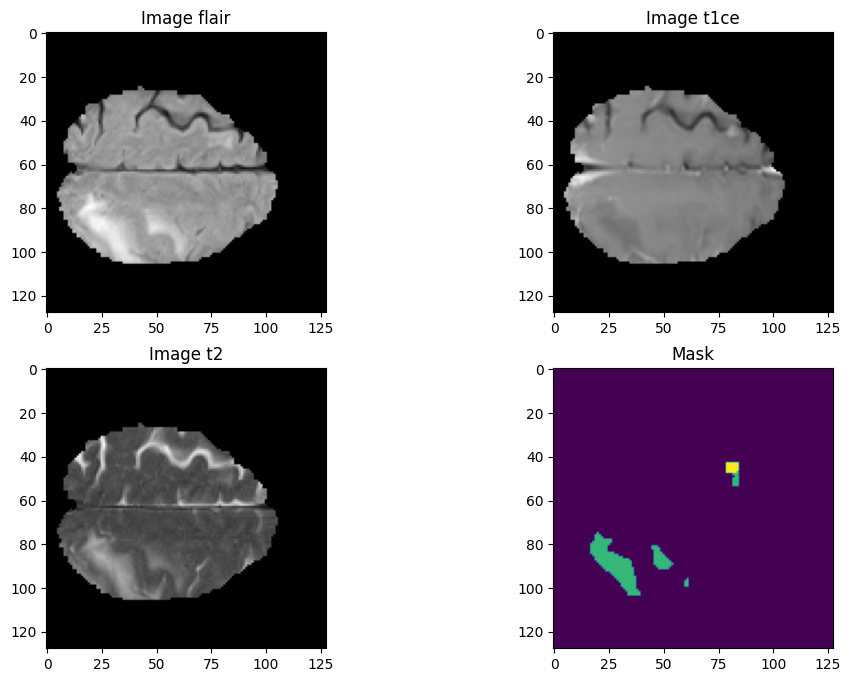

In [6]:

from matplotlib import pyplot as plt
import random

train_img_dir = "ml2-input_data_128/train/images/"
train_mask_dir = "ml2-input_data_128/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [5]:
import os
import numpy as np
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random


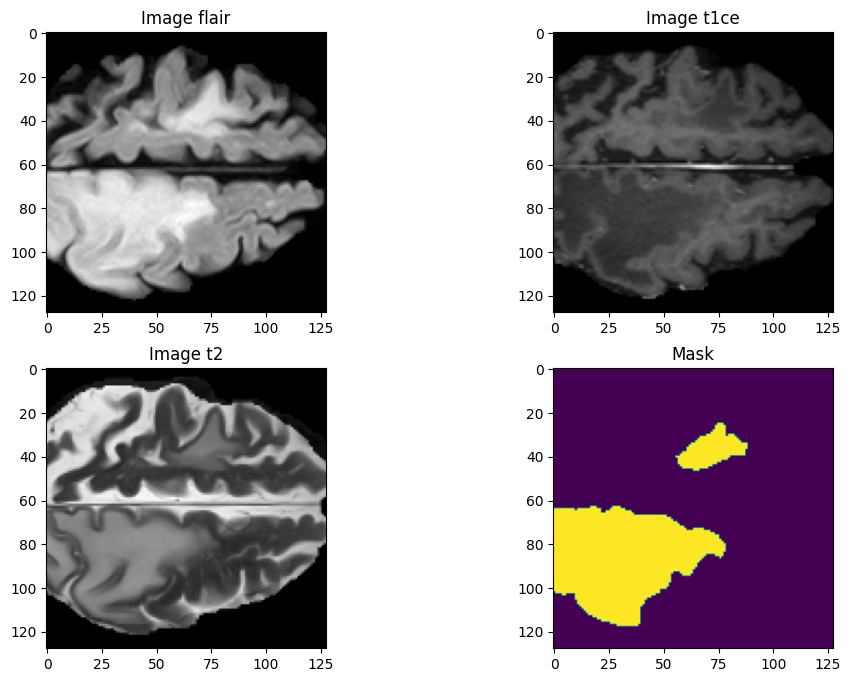

In [27]:
train_img_dir = "input_data_128/train/images/"
train_mask_dir = "input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [28]:
import pandas as pd
import numpy as np
import glob

columns = ['0', '1', '2', '3']
data_list = []
train_mask_list = sorted(glob.glob('input_data_128/train/masks/*.npy'))

for img in range(len(train_mask_list)):
    print(img)
    temp_image = np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    
    # Create a dictionary with default 0 counts for missing labels
    conts_dict = {col: 0 for col in columns}
    conts_dict.update(dict(zip(map(str, val), counts)))  # Update with actual counts
    
    data_list.append(conts_dict)  # Collect dictionary for each image

# Create the DataFrame from list of dictionaries
df = pd.DataFrame(data_list)

# Calculate label sums
label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

# Class weights calculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels / (n_classes * label_0)), 2)
wt1 = round((total_labels / (n_classes * label_1)), 2)
wt2 = round((total_labels / (n_classes * label_2)), 2)
wt3 = round((total_labels / (n_classes * label_3)), 2)
print(wt0, wt1, wt2, wt3)
#0.26 149.26 5.74 27.16

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
0.26 101.69 6.86 41.28


DEFINING THE MODEL 

In [29]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 128, 128, 128, 3)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_88 (Conv3D)            │ (None, 128, 128, 128, 16) │           1,312 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_36 (Dropout)          │ (None, 128, 128, 128, 16) │               0 │ conv3d_88[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_89 (Conv3D)            │ (None, 128, 128, 128, 16) │           6,928 │ dropout_36[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_16              │ (None, 64, 64, 64, 16)    │               0 │ conv3d_89[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_90 (Conv3D)            │ (None, 64, 64, 64, 32)    │          13,856 │ max_pooling3d_16[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_37 (Dropout)          │ (None, 64, 64, 64, 32)    │               0 │ conv3d_90[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_91 (Conv3D)            │ (None, 64, 64, 64, 32)    │          27,680 │ dropout_37[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_17              │ (None, 32, 32, 32, 32)    │               0 │ conv3d_91[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_92 (Conv3D)            │ (None, 32, 32, 32, 64)    │          55,360 │ max_pooling3d_17[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_38 (Dropout)          │ (None, 32, 32, 32, 64)    │               0 │ conv3d_92[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_93 (Conv3D)            │ (None, 32, 32, 32, 64)    │         110,656 │ dropout_38[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_18              │ (None, 16, 16, 16, 64)    │               0 │ conv3d_93[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_94 (Conv3D)            │ (None, 16, 16, 16, 128)   │         221,312 │ max_pooling3d_18[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_39 (Dropout)          │ (None, 16, 16, 16, 128)   │               0 │ conv3d_94[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_95 (Conv3D)            │ (None, 16, 16, 16, 128)   │         442,49

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


TRAINING THE MODEL

In [8]:
train_img_dir = "input_data_128/train/images/"
train_mask_dir = "input_data_128/train/masks/"

val_img_dir = "input_data_128/val/images/"
val_mask_dir = "input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)


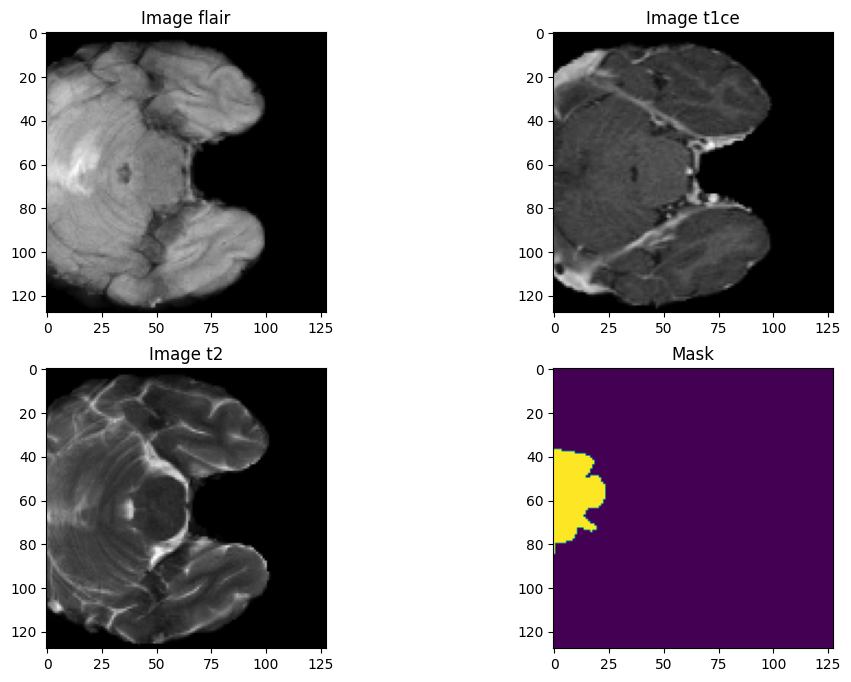

In [11]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()



LOSS AND METRICS DEFINITION

In [32]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [33]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model2 = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model2.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model2.summary())

print(model2.input_shape)
print(model2.output_shape)

history=model2.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model2.save('ml2-brats_3d.hdf5')

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 128, 128, 128, 3)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_107 (Conv3D)           │ (None, 128, 128, 128, 16) │           1,312 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_45 (Dropout)          │ (None, 128, 128, 128, 16) │               0 │ conv3d_107[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_108 (Conv3D)           │ (None, 128, 128, 128, 16) │           6,928 │ dropout_45[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_20              │ (None, 64, 64, 64, 16)    │               0 │ conv3d_108[0][0]           │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_109 (Conv3D)           │ (None, 64, 64, 64, 32)    │          13,856 │ max_pooling3d_20[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_46 (Dropout)          │ (None, 64, 64, 64, 32)    │               0 │ conv3d_109[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_110 (Conv3D)           │ (None, 64, 64, 64, 32)    │          27,680 │ dropout_46[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_21              │ (None, 32, 32, 32, 32)    │               0 │ conv3d_110[0][0]           │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_111 (Conv3D)           │ (None, 32, 32, 32, 64)    │          55,360 │ max_pooling3d_21[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_47 (Dropout)          │ (None, 32, 32, 32, 64)    │               0 │ conv3d_111[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_112 (Conv3D)           │ (None, 32, 32, 32, 64)    │         110,656 │ dropout_47[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_22              │ (None, 16, 16, 16, 64)    │               0 │ conv3d_112[0][0]           │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_113 (Conv3D)           │ (None, 16, 16, 16, 128)   │         221,312 │ max_pooling3d_22[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_48 (Dropout)          │ (None, 16, 16, 16, 128)   │               0 │ conv3d_113[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_114 (Conv3D)           │ (None, 16, 16, 16, 128)   │         442,49

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 128, 128, 128, 3)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_107 (Conv3D)           │ (None, 128, 128, 128, 16) │           1,312 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_45 (Dropout)          │ (None, 128, 128, 128, 16) │               0 │ conv3d_107[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_108 (Conv3D)           │ (None, 128, 128, 128, 16) │           6,928 │ dropout_45[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_20              │ (None, 64, 64, 64, 16)    │               0 │ conv3d_108[0][0]           │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_109 (Conv3D)           │ (None, 64, 64, 64, 32)    │          13,856 │ max_pooling3d_20[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_46 (Dropout)          │ (None, 64, 64, 64, 32)    │               0 │ conv3d_109[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_110 (Conv3D)           │ (None, 64, 64, 64, 32)    │          27,680 │ dropout_46[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_21              │ (None, 32, 32, 32, 32)    │               0 │ conv3d_110[0][0]           │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_111 (Conv3D)           │ (None, 32, 32, 32, 64)    │          55,360 │ max_pooling3d_21[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_47 (Dropout)          │ (None, 32, 32, 32, 64)    │               0 │ conv3d_111[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_112 (Conv3D)           │ (None, 32, 32, 32, 64)    │         110,656 │ dropout_47[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_22              │ (None, 16, 16, 16, 64)    │               0 │ conv3d_112[0][0]           │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_113 (Conv3D)           │ (None, 16, 16, 16, 128)   │         221,312 │ max_pooling3d_22[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_48 (Dropout)          │ (None, 16, 16, 16, 128)   │               0 │ conv3d_113[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_114 (Conv3D)           │ (None, 16, 16, 16, 128)   │         442,49

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 682s 27s/step - accuracy: 0.5300 - iou_score: 0.0438 - loss: 1.0033 - val_accuracy: 0.9523 - val_iou_score: 0.1650 - val_loss: 0.9687
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 680s 27s/step - accuracy: 0.9505 - iou_score: 0.2182 - loss: 0.9563 - val_accuracy: 0.9537 - val_iou_score: 0.1487 - val_loss: 0.9604
Epoch 3/50
 9/25 ━━━━━━━━━━━━━━━━━━━━ 7:12 27s/step - accuracy: 0.9521 - iou_score: 0.2305 - loss: 0.9488

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/functional_11_1/conv3d_119_1/convolution/Conv3DBackpropFilterV2 defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a primitive, in file tensorflow/core/kernels/mkl/mkl_conv_grad_filter_ops.cc:685
	 [[{{node StatefulPartitionedCall/gradient_tape/functional_11_1/conv3d_119_1/convolution/Conv3DBackpropFilterV2}}]] [Op:__inference_one_step_on_iterator_28704]

**ATTENTION U-NET MODEL**

In [9]:
from keras.layers import multiply, add, Activation
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
kernel_initializer =  'he_uniform'
def attention_block(x, gating, inter_channels):
    theta_x = Conv3D(inter_channels, (1, 1, 1), padding='same')(x)
    phi_g = Conv3D(inter_channels, (1, 1, 1), padding='same')(gating)
    add_xg = add([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    psi = Conv3D(1, (1, 1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    return multiply([x, sigmoid_xg])

def attention_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    # Contracting Path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
    
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
    
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
    
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    # Expansive Path with Attention Gates
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = attention_block(c4, u6, 128)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
    
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = attention_block(c3, u7, 64)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
    
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = attention_block(c2, u8, 32)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
    
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = attention_block(c1, u9, 16)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
    
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model

# Test the Attention U-Net
attention_unet = attention_unet_model(128, 128, 128, 3, 4)
print(attention_unet.input_shape)
print(attention_unet.output_shape)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 128, 3)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d (Conv3D)               │ (None, 128, 128, 128, 16) │           1,312 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128, 128, 128, 16) │               0 │ conv3d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_1 (Conv3D)             │ (None, 128, 128, 128, 16) │           6,928 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d (MaxPooling3D)  │ (None, 64, 64, 64, 16)    │               0 │ conv3d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_2 (Conv3D)             │ (None, 64, 64, 64, 32)    │          13,856 │ max_pooling3d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64, 64, 64, 32)    │               0 │ conv3d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_3 (Conv3D)             │ (None, 64, 64, 64, 32)    │          27,680 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_1               │ (None, 32, 32, 32, 32)    │               0 │ conv3d_3[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_4 (Conv3D)             │ (None, 32, 32, 32, 64)    │          55,360 │ max_pooling3d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 32, 32, 32, 64)    │               0 │ conv3d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_5 (Conv3D)             │ (None, 32, 32, 32, 64)    │         110,656 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_2               │ (None, 16, 16, 16, 64)    │               0 │ conv3d_5[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_6 (Conv3D)             │ (None, 16, 16, 16, 128)   │         221,312 │ max_pooling3d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 16, 16, 16, 128)   │               0 │ conv3d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_7 (Conv3D)             │ (None, 16, 16, 16, 128)   │         442,496 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,690,072 (21.71 MB)

 Trainable params: 5,690,072 (21.71 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [10]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `keras` framework.


In [11]:
# Define the Attention U-Net model
batch_size = 2
attention_unet = attention_unet_model(IMG_HEIGHT=128, 
                                      IMG_WIDTH=128, 
                                      IMG_DEPTH=128, 
                                      IMG_CHANNELS=3, 
                                      num_classes=4)

# Compile the Attention U-Net model
attention_unet.compile(optimizer=optim, loss=total_loss, metrics=metrics)

# Display the model summary
attention_unet.summary()

# Training parameters
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

# Fit the Attention U-Net model
history2 = attention_unet.fit(
    train_img_datagen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    verbose=1,
    validation_data=val_img_datagen,
    validation_steps=val_steps_per_epoch,
)

# Save the trained model
attention_unet.save('ml2-brats_attention_unet_3d.hdf5')


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 128, 3)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_31 (Conv3D)            │ (None, 128, 128, 128, 16) │           1,312 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 128, 128, 128, 16) │               0 │ conv3d_31[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_32 (Conv3D)            │ (None, 128, 128, 128, 16) │           6,928 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_4               │ (None, 64, 64, 64, 16)    │               0 │ conv3d_32[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_33 (Conv3D)            │ (None, 64, 64, 64, 32)    │          13,856 │ max_pooling3d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 64, 64, 64, 32)    │               0 │ conv3d_33[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_34 (Conv3D)            │ (None, 64, 64, 64, 32)    │          27,680 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_5               │ (None, 32, 32, 32, 32)    │               0 │ conv3d_34[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_35 (Conv3D)            │ (None, 32, 32, 32, 64)    │          55,360 │ max_pooling3d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 32, 32, 32, 64)    │               0 │ conv3d_35[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_36 (Conv3D)            │ (None, 32, 32, 32, 64)    │         110,656 │ dropout_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_6               │ (None, 16, 16, 16, 64)    │               0 │ conv3d_36[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_37 (Conv3D)            │ (None, 16, 16, 16, 128)   │         221,312 │ max_pooling3d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 16, 16, 16, 128)   │               0 │ conv3d_37[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_38 (Conv3D)            │ (None, 16, 16, 16, 128)   │         442,49

 Total params: 5,690,072 (21.71 MB)

 Trainable params: 5,690,072 (21.71 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 128, 3)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_31 (Conv3D)            │ (None, 128, 128, 128, 16) │           1,312 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 128, 128, 128, 16) │               0 │ conv3d_31[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_32 (Conv3D)            │ (None, 128, 128, 128, 16) │           6,928 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_4               │ (None, 64, 64, 64, 16)    │               0 │ conv3d_32[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_33 (Conv3D)            │ (None, 64, 64, 64, 32)    │          13,856 │ max_pooling3d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 64, 64, 64, 32)    │               0 │ conv3d_33[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_34 (Conv3D)            │ (None, 64, 64, 64, 32)    │          27,680 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_5               │ (None, 32, 32, 32, 32)    │               0 │ conv3d_34[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_35 (Conv3D)            │ (None, 32, 32, 32, 64)    │          55,360 │ max_pooling3d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 32, 32, 32, 64)    │               0 │ conv3d_35[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_36 (Conv3D)            │ (None, 32, 32, 32, 64)    │         110,656 │ dropout_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_6               │ (None, 16, 16, 16, 64)    │               0 │ conv3d_36[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_37 (Conv3D)            │ (None, 16, 16, 16, 128)   │         221,312 │ max_pooling3d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 16, 16, 16, 128)   │               0 │ conv3d_37[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_38 (Conv3D)            │ (None, 16, 16, 16, 128)   │         442,49

 Total params: 5,690,072 (21.71 MB)

 Trainable params: 5,690,072 (21.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 425s 17s/step - accuracy: 0.3801 - iou_score: 0.0211 - loss: 1.0243 - val_accuracy: 0.9318 - val_iou_score: 3.9324e-08 - val_loss: 1.0036
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 722s 29s/step - accuracy: 0.9329 - iou_score: 0.0274 - loss: 0.9960 - val_accuracy: 0.9541 - val_iou_score: 0.1397 - val_loss: 0.9774
Epoch 3/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 5:14 13s/step - accuracy: 0.9391 - iou_score: 0.1408 - loss: 0.9772

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/functional_3_1/conv3d_49_1/convolution/Conv3DBackpropFilterV2 defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a primitive, in file tensorflow/core/kernels/mkl/mkl_conv_grad_filter_ops.cc:685
	 [[{{node StatefulPartitionedCall/gradient_tape/functional_3_1/conv3d_49_1/convolution/Conv3DBackpropFilterV2}}]] [Op:__inference_one_step_on_iterator_13652]